In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.mlab as mlab
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import math
import seaborn as sns
from six.moves import cPickle as pickle
import csv
import sys
import pandas as pd
import time

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller

import matplotlib.lines as mlines
import re
from scipy import optimize

import matplotlib.colors as colors2
import matplotlib.cm as cmx

import numpy.polynomial.polynomial as poly

from pyemd import emd
# https://github.com/wmayner/pyemd
# Ofir Pele and Michael Werman, "Fast and robust earth mover's distances," in Proc. 2009 IEEE 
# 12th Int. Conf. on Computer Vision, Kyoto, Japan, 2009, pp. 460-467.

from multiprocessing import Pool

%matplotlib inline
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', \
               'xtick.minor.size': 3.0, 'ytick.minor.size': 3.0, 'grid.linewidth': 0.})

In [3]:
# load the data
consumption_df = pd.read_pickle('../cleanedLoadData/consumption_df_round3.pickle')

In [5]:

print('There are now', len(consumption_df), 'users')

There are now 255 users


In [6]:
consumption_df.head()

,user_id,cities,states,2015-01-01 00:00:00,2015-01-01 00:15:00,2015-01-01 00:30:00,2015-01-01 00:45:00,2015-01-01 01:00:00,2015-01-01 01:15:00,2015-01-01 01:30:00,...,2015-12-31 21:30:00,2015-12-31 21:45:00,2015-12-31 22:00:00,2015-12-31 22:15:00,2015-12-31 22:30:00,2015-12-31 22:45:00,2015-12-31 23:00:00,2015-12-31 23:15:00,2015-12-31 23:30:00,2015-12-31 23:45:00
1,3935,Austin,Texas,0.327,0.230,0.224,0.222,0.199,0.189,0.188,...,0.180,0.213,0.203,0.220,0.229,0.179,0.0,0.0,0.0,0.0
2,668,Austin,Texas,0.380,0.270,0.246,0.193,0.204,0.215,0.219,...,0.095,0.060,0.060,0.079,0.117,0.089,0.0,0.0,0.0,0.0
3,6412,Austin,Texas,0.484,0.329,0.292,0.222,0.215,0.220,0.230,...,0.223,0.194,0.233,0.223,0.203,0.215,0.0,0.0,0.0,0.0
4,5814,Austin,Texas,0.369,0.235,0.047,0.096,0.093,0.028,0.027,...,0.114,0.113,0.113,0.095,0.091,0.091,0.0,0.0,0.0,0.0
5,8046,Austin,Texas,0.169,0.131,0.093,0.072,0.087,0.072,0.088,...,0.183,0.190,0.181,0.176,0.290,0.251,0.0,0.0,0.0,0.0


In [7]:
cIDs = consumption_df.user_id.unique()
consumption_df = consumption_df.set_index('user_id')

In [8]:
min15_df = consumption_df.iloc[:,2:]

In [9]:
min15Vals = min15_df.iloc[:,:].values

In [11]:
# change the vals to hourly
[a,b] = np.shape(min15Vals)
hourlyVals = np.zeros((a,int(b/4)))
for j in range(int(b/4)):
    hourlyVals[:,j] = np.sum(min15Vals[:,j*4+0:(j+1)*4], axis=1)

In [12]:
# make an hourly dataframe
colsT = pd.date_range(start='1/1/2015', end='1/1/2016', freq='1H')[0:-1]
print(len(colsT))
hourly_df = pd.DataFrame(hourlyVals, index=np.arange(a), columns=colsT)

hourly_df['user_id'] = cIDs
hourly_df = hourly_df.set_index('user_id')

8760


In [13]:
# first lets look at the consumption data - aggregate plus a couple of individual
aggregateLoad = hourly_df.sum(axis=0)

In [14]:
startTrain,endTrain,startPred,endPred = 0,5832,5832,7296

In [15]:
arimaTestData = aggregateLoad[startTrain:endTrain]

In [16]:
### make an ARIMA model

In [17]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [18]:
# look at the timeseries and its stationarity
arimaTestDiff = arimaTestData.diff(1)
arimaTestSeason = arimaTestData.diff(24)
arimaTestDiffPlusSeason = arimaTestDiff - arimaTestSeason

# remove nans by using df.dropna()

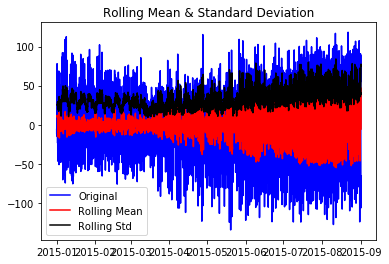

Results of Dickey-Fuller Test:
Test Statistic                -1.614913e+01
p-value                        4.589371e-29
#Lags Used                     3.400000e+01
Number of Observations Used    5.796000e+03
Critical Value (1%)           -3.431479e+00
Critical Value (5%)           -2.862039e+00
Critical Value (10%)          -2.567036e+00
dtype: float64


In [19]:
test_stationarity(arimaTestDiff.dropna())

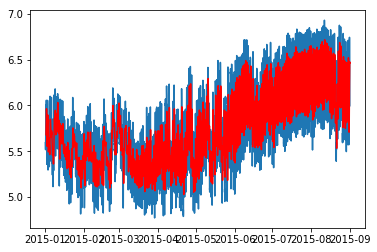

In [20]:
ts_log = np.log(arimaTestData)
moving_avg = ts_log.rolling(window=12,center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [21]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(arimaTestData,
                                order=(0, 0, 0),
                                seasonal_order = (1,1,1,12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

/Users/edwardbarbour/Desktop/virtualEnvs/loadForecasting/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [22]:
# print statistics
print(res.aic)
print(res.summary())

63688.48308741012
                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                 5832
Model:             SARIMAX(1, 1, 1, 12)   Log Likelihood              -31841.242
Date:                  Mon, 26 Nov 2018   AIC                          63688.483
Time:                          16:38:50   BIC                          63708.490
Sample:                      01-01-2015   HQIC                         63695.442
                           - 08-31-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9865      0.002   -431.847      0.000      -0.991      -0.982
ma.S.L12       0.2941      0.014     20.873      0.000       0.266       0.322
sigma2      3287.8

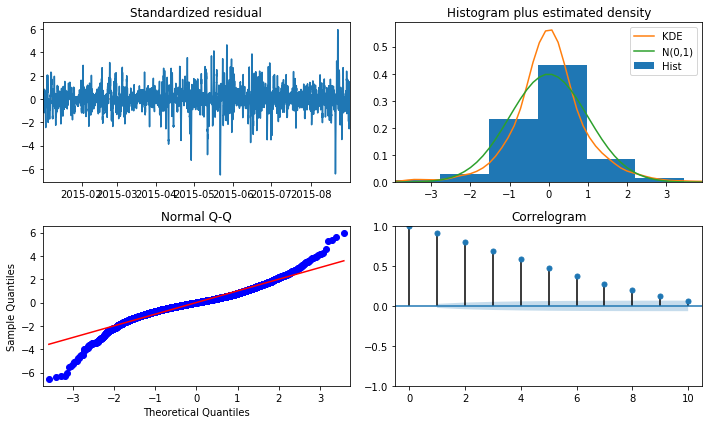

In [23]:
res.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

In [24]:
X = aggregateLoad.values

In [25]:
import warnings
import itertools
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

In [26]:
train = arimaTestData.values

def eval_mdl(mdlParams,train):
    # use at least one day history, so first prediction is for train[47]
    predictions = np.zeros((len(train)-47))
    for t in range(len(train)-47):
        history = train[0:24+t]
        modTest = sm.tsa.statespace.SARIMAX(history,
                                    order=param,
                                    seasonal_order=seasonal_param,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
        modTestResults = modTest.filter(results.params)
        # now generate a forecast for train[t+47]
        predictions[t] = modTestResults.forecast(steps=24)[23]
    APEs = np.abs(predictions-train[47:])/np.abs(train[47:])
    return np.mean(APEs)

In [ ]:
ti = time.time()
best_MAPE = np.inf
best_pdq = None
best_seasonal = None
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            #seasonal_param = (1,0,0,24)
            #param = (1,0,0)
            print('ARIMA{}x{}'.format(param, seasonal_param))
            sys.stdout.flush()
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            # generate a 24 hr ahead rolling forecast
            MAPE = eval_mdl(results.params, train)

            print('MAPE:{} \n'.format(MAPE))  
            sys.stdout.flush()
            
            if MAPE < best_MAPE:
                best_MAPE = 0+MAPE
                best_pdq = param
                best_seasonal = seasonal_param
        except:
            continue
            
print('elapsed time: %.2f'%(time.time()-ti))
# f = open('arimaBestFile.dat', 'wb')
# f.write('ARIMA{}x{}, MAPE:{} \n'.format(best_pdq, best_seasonal, best_MAPE))
# f.close()

ARIMA(0, 0, 0)x(0, 0, 0, 24)
MAPE:1.0 

ARIMA(0, 0, 0)x(0, 0, 1, 24)
ARIMA(0, 0, 0)x(0, 1, 0, 24)


In [ ]:
len(train)-47

In [ ]:
best_pdq, best_seasonal

In [ ]:
## create the model and train it using the training data
train, test = X[0:endTrain], X[startPred:endPred]

normalOrder = np.copy(best_pdq)
seasonalOrder = np.copy(best_seasonal)

training_mdl = sm.tsa.statespace.SARIMAX(train,
                                order=normalOrder, 
                                seasonal_order=seasonalOrder,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
training_res = training_mdl.fit()

In [ ]:
## create the model to do the predictions and use the same parameters as from the training
ti = time.time()
mdlOneStepAhead = sm.tsa.statespace.SARIMAX(X[0:endPred],
                                order=normalOrder,
                                seasonal_order = seasonalOrder,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
resOneStepAhead = mdlOneStepAhead.filter(training_res.params)
print('elapsed time = :%.2f'%(time.time()-ti))

In [ ]:
## insample prediction 1 step ahead
insample = resOneStepAhead.predict()

APEsOneStep = np.abs(insample[startPred:endPred]-test)/np.abs(test)
print('one stpe ahead MAPE', np.mean(APEsOneStep))

In [ ]:
newColors = sns.color_palette()

In [ ]:
## now make a rolling forecast for a day and inspect
ti = time.time()

prediction24 = np.zeros((24))

for t in range(24):
    #print t
    sys.stdout.flush()
    mdlDayAhead = sm.tsa.statespace.SARIMAX(X[0:startPred+t-23],
                                order=normalOrder,
                                seasonal_order = seasonalOrder,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    # use already fitted params
    resDayAhead = mdlDayAhead.filter(training_res.params)
    prediction24[t] = resDayAhead.forecast(steps=24)[23]
    if t==0:
        forecast_at_start = res.forecast(steps=24)
forecast_at_end = res.forecast(steps=24)
print(forecast_at_start[0], X[startPred-23])

In [ ]:
testPlot = np.zeros((48))
testPlot[0:24] = forecast_at_start
testPlot[24:] = prediction24
fig = plt.figure(figsize = (6,4))
# look at 3 days before
startGraph = startPred-3*24
ax1 = fig.add_subplot(111)
l1, = ax1.plot(np.arange(0,72), X[startGraph:startPred], color=newColors[0])
l2, = ax1.plot(np.arange(72,96), forecast_at_end, color=newColors[1])
l3, = ax1.plot(np.arange(72,96), X[startPred:startPred+24], color=newColors[2])
l4, = ax1.plot(np.arange(48,96), testPlot, color=newColors[3])
ax1.set_xlim([0,96])
ax1.legend([l1,l2,l3,l4],['history','forecast at startPred','actual', 'rolling forecast'])